In [1]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

Problem is
$$\text{min } \frac{1}{2} x^TQx+p^Tx\\
\text{s.t. } Ax=b\\
l\leq x \leq u$$

Generating Data

In [2]:
# Generates a Quadratic problem data
def generate_data(n, m, mean, std, lower, upper, alpha):
  # M = np.random.normal(mean, std, (n, n))

  M = np.zeros((n,n))
  num_nonzero = int(n * n * 0.15)
  indices = np.random.choice(n * n, num_nonzero, replace=False)
  for i in indices:
    row = i // n
    col = i % n
    M[row, col] = np.random.normal(mean, std)

  P = M @ M.T + alpha * np.eye(n)
  

  # A = np.random.normal(mean, std, (m, n))

  A = np.zeros((m,n))
  num_nonzero = int(m * n * 0.15)
  indices = np.random.choice(m * n, num_nonzero, replace=False)
  for i in indices:
    row = i // n
    col = i % n
    A[row, col] = np.random.normal(mean, std)


  q = np.random.normal(mean, std, n)

  u = np.random.uniform(lower, upper, m)
  l = -np.random.uniform(lower, upper, m)

  return {
      'P' : P,
      'A' : A,
      'q' : q,
      'u' : u,
      'l' : l
  }
 
# Generate the problem instances 
def problem_instance(distribution, dimensions, num_instances=10):
  
  # Gaussian dist param
  mean, std = distribution['mean'], distribution['std']
  
  # Uniform dist param
  lower, upper = distribution['lower'], distribution['upper']
  
  # Prob Dimensions
  n, m = dimensions['n'], dimensions['m']
  alpha = dimensions['alpha']
  
  # Generating the problem instances
  prob_instances = {}

  for i in range(num_instances):
    key = f'set_{i+1}'
    prob_instances[key] = generate_data(n, m, mean, std, lower, upper, alpha)
    
  return prob_instances

In [3]:
# Calling function to generate data
distribution = {'mean': 0, 'std': 1, 'lower': 0, 'upper': 1}
dimensions = {'n': 100, 'm': 50, 'alpha': 10**-2}
num_instances = 5

# num_instances is by default 10 so no need to include it, but we can generate an
# arbitrary amount by sending in num_instances=5
problem_data = problem_instance(distribution, dimensions, num_instances)

Perturbing Data

In [4]:
np.random.seed(42)
# Setting the parameters
set_x = 'set_2'

P = problem_data[set_x]['P']
p = problem_data[set_x]['q']
A = problem_data[set_x]['A']

# Making the matrix PSD instead of PD
eigenval = sorted(np.linalg.eigvals(P))
Q = P - np.eye(P.shape[1]) * (eigenval[0] - 1e-15)

x_temp = np.abs(np.random.normal(-30, 50, A.shape[1]))

b = A @ x_temp + np.abs(np.random.randn(A.shape[0]))

u = x_temp + np.abs(np.random.normal(0, 10, A.shape[1]))
l = x_temp - np.abs(np.random.normal(0, 10, A.shape[1]))

CVXPY

In [5]:
x_cvxpy = cp.Variable(A.shape[1])
objective = cp.Minimize(0.5 * cp.quad_form(x_cvxpy, Q) + p.T @ x_cvxpy)
constraints = [A @ x_cvxpy == b, x_cvxpy >= l, x_cvxpy <= u]
problem = cp.Problem(objective, constraints)
problem.solve()
print("CVXPY objective value", objective.value)

CVXPY objective value 1833702.5135119364


ADMM

In [6]:
def box_project(x, l, u):
    z = np.empty(x.shape[0])
    for i in range(z.shape[0]):
        if l[i] <= x[i] and x[i] <= u[i]:
            z[i] = x[i]
        elif x[i] < l[i]:
            z[i] = l[i]
        elif x[i] > u[i]:
            z[i] = u[i]
        else:
            print("error in projection")
    return z

In [7]:
iterations = 5000

rho = 0.9

top = np.hstack([Q + rho*np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

lu = splu(matrix)

x = z = mu = np.zeros(Q.shape[1])
obj_val = []

for i in range(iterations):
    left = np.hstack([p - rho*(z-mu), -b])
    x = -lu.solve(left)[:Q.shape[1]]
    z = box_project(x+mu, l, u)
    mu = mu + x - z
    obj_val.append(0.5*x@Q@x + p@x)

C:\Users\baice\AppData\Local\Temp\ipykernel_1572\3934210270.py:9: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix)


y-axis vals:
 [0.7499 0.7226 0.6978 ... 0.0022 0.0022 0.0022]


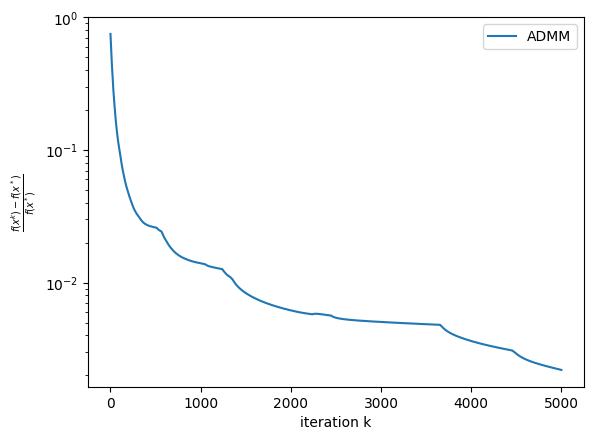

In [24]:
plt.plot(np.abs((obj_val-problem.value)/problem.value), label="ADMM")
plt.xlabel("iteration k")
plt.ylabel(r"$\frac{f(x^k) - f(x^*)}{f(x^*)}$")
plt.yscale('log')
plt.legend()
print("y-axis vals:\n",np.abs((obj_val-problem.value)/problem.value))

ADMM Fixed Restarts

In [21]:
iterations = 5000

rho = 0.9
k = 700

top = np.hstack([Q + rho*np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

lu = splu(matrix)

xu = xv = y = np.zeros(Q.shape[1])
xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])
obj_val_fix_rest = []

for j in range(int(iterations/k)):
    for t in range(k):
        left = np.hstack([p - rho*(xv-y), -b])
        xu_next = -lu.solve(left)[:Q.shape[1]]
        xv_next = box_project(xu_next+y, l, u)
        y_next = y + xu_next - xv_next
        
        xu_bar = (t/(t+1)) * xu_bar + (1/(t+1)) * xu_next
        xv_bar = (t/(t+1)) * xv_bar + (1/(t+1)) * xv_next
        
        y_hat = y + xu_next - xv
        y_bar = (t/(t+1)) * y_bar + (1/(t+1)) * y_hat
        
        xu = xu_next
        xv = xv_next
        y = y_next
        obj_val_fix_rest.append(0.5*xu@Q@xu + p@xu)
    
    xu = xu_bar
    xv = xv_bar
    y = y_bar
    xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])

C:\Users\baice\AppData\Local\Temp\ipykernel_1572\1940875079.py:10: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix)


y-axis vals:
 [0.7499 0.7226 0.6978 ... 0.0052 0.0052 0.0052]


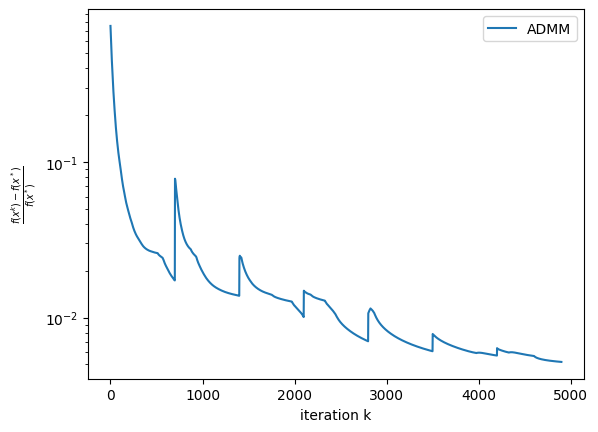

In [23]:
plt.plot(np.abs((obj_val_fix_rest-problem.value)/problem.value), label="ADMM")
plt.xlabel("iteration k")
plt.ylabel(r"$\frac{f(x^k) - f(x^*)}{f(x^*)}$")
plt.yscale('log')
plt.legend()
print("y-axis vals:\n",np.abs((obj_val_fix_rest-problem.value)/problem.value))

ADMM KKT Restarts

We define the KKT error as
$$\text{KKT}_w(z) = \sqrt{w^2||Ax-b||^2_2+\frac{1}{w^2}||Qx+p-y^TA-\lambda||^2_2 + [b^Ty+l^T\lambda^+-u^T\lambda^--\frac{1}{2}x^TQx-p^Tx]^2 }$$

In [38]:
def KKT_error(w, A, b, Q, p, l, u, x, y, lam, lam_pos, lam_neg):
    norm1 = np.linalg.norm(A @ x - b, 2) ** 2
    norm2 = np.linalg.norm(Q @ x + p - y.T @ A - lam, 2) ** 2
    term3 = (b.T @ y + l.T @ lam_pos - u.T @ lam_neg - ((1/2) * x.T @ Q @ x + p.T @ x)) ** 2
    
    kkt = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + term3)
    
    return kkt

def lam_comp(A, x, b, u, l, Q, p, dual_var):
    lam_pos = np.ones(x.shape[0])
    lam_neg = np.ones(x.shape[0])
    
    for i in range(x.shape[0]):
        if not abs(x[i] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        elif not abs(x[i] - u[i]) <= 1e-5:
            lam_neg[i] = 0
    
    for i in range(x.shape[0]):
        if lam_pos[i] != 0:
            lam_pos[i] = ((Q @ x + p - dual_var.T @ A)[i]) / l[i]
        elif lam_neg[i] != 0:
            lam_neg[i] = ((dual_var.T @ A - Q @ x - p)[i]) / u[i]
    
    lam = np.vstack([lam_pos, lam_neg])
    
    return lam

In [72]:
iterations = 5000

rho = 0.9

top = np.hstack([Q + rho*np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

lu = splu(matrix)

# Dual variable for the Ax=b constraint
dual_var = np.zeros(A.shape[0])
# The ADMM iterates
xu = xv = y = np.zeros(Q.shape[1])
xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])
obj_val_kkt_rest = []

lam = lam_comp(A, xv, b, u, l, Q, p, dual_var)
lam_pos = lam[0]
lam_neg = lam[1]


KKT_prev = np.zeros(20, dtype=object)
kkt = KKT_error(rho, A, b, Q, p, l, u, xv, dual_var, lam, lam_pos, lam_neg)
KKT_prev[0] = KKT_prev[1] = -np.inf
KKT_n = -np.inf

count = 0
temp = 0
for i in range(iterations):
    t = 0
    while not ((kkt <= 0.8 * KKT_n and kkt > KKT_prev[0]) or (kkt <= 0.2 * KKT_n) or (t >= max(0.36 * iterations,1))):
        # if not (t+1 >= max(0.36 * count,1)):
        if not (t+1 >= max(0.36 * iterations,1)):
            temp += 1
        left = np.hstack([p - rho*(xv-y), -b])
        lu_solve = -lu.solve(left)
        xu_next = lu_solve[:Q.shape[1]]
        dual_var = lu_solve[Q.shape[1]:]
        xv_next = box_project(xu_next+y, l, u)
        y_next = y + xu_next - xv_next
        
        xu_bar = (t/(t+1)) * xu_bar + (1/(t+1)) * xu_next
        xv_bar = (t/(t+1)) * xv_bar + (1/(t+1)) * xv_next
        
        y_hat = y + xu_next - xv
        y_bar = (t/(t+1)) * y_bar + (1/(t+1)) * y_hat
        
        xu = xu_next
        xv = xv_next
        y = y_next
        obj_val_kkt_rest.append(0.5*xu@Q@xu + p@xu)
        
        
        # We let the x be xv (aka the value after the projections are made)
        lam = lam_comp(A, xv, b, u, l, Q, p, dual_var)
        lam_pos = lam[0]
        lam_neg = lam[1]
        lam_KKT = lam_pos - lam_neg
        
        kkt = KKT_error(rho, A, b, Q, p, l, u, xv, dual_var, lam, lam_pos, lam_neg)
        KKT_prev[0] = KKT_prev[1]
        KKT_prev[1] = kkt
        
        t += 1
        count += 1
        if count >= iterations:
            break
    if count >= iterations:
        break
    KKT_n = kkt
    xu = xu_bar
    xv = xv_bar
    y = y_bar
    xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])

C:\Users\baice\AppData\Local\Temp\ipykernel_1572\1122129137.py:9: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix)


In [73]:
print("Number of time we break out of inner loop due to not (t >= max(0.36 * count,1)) holding is", temp)

Number of time we break out of inner loop due to not (t >= max(0.36 * count,1)) holding is 4998


y-axis vals:
 [0.7499 0.7226 0.6978 ... 0.005  0.005  0.005 ]


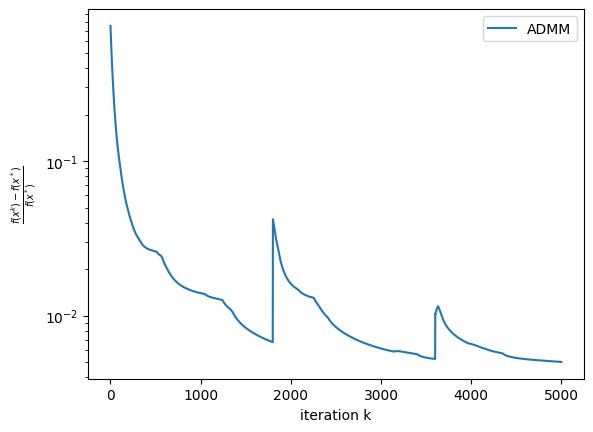

In [74]:
plt.plot(np.abs((obj_val_kkt_rest-problem.value)/problem.value), label="ADMM")
plt.xlabel("iteration k")
plt.ylabel(r"$\frac{f(x^k) - f(x^*)}{f(x^*)}$")
plt.yscale('log')
plt.legend()
print("y-axis vals:\n",np.abs((obj_val_kkt_rest-problem.value)/problem.value))

ADMM with PD approximation

In [110]:
iterations = 3000

rho = 0.9

top = np.hstack([Q + rho*np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

lu = splu(matrix)

x = z = mu = np.zeros(Q.shape[1])
obj_val_2 = []

for i in range(iterations):
    left = np.hstack([p - rho*(z-mu), -b])
    x = -lu.solve(left)[:Q.shape[1]]
    z = box_project(x+mu, l, u)
    mu = mu + x - z
    obj_val_2.append(0.5*x@Q@x + p@x)

C:\Users\baice\AppData\Local\Temp\ipykernel_1572\2744819186.py:9: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix)


y-axis vals:
 [0.7499 0.7226 0.6978 ... 0.0051 0.0051 0.0051]


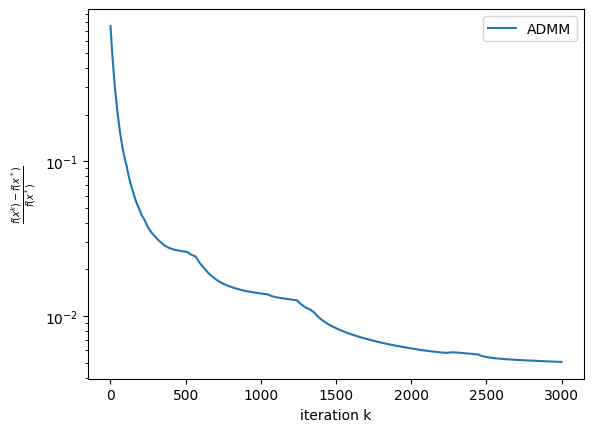

In [111]:
plt.plot(np.abs((obj_val_2-problem.value)/problem.value), label="ADMM")
plt.xlabel("iteration k")
plt.ylabel(r"$\frac{f(x^k) - f(x^*)}{f(x^*)}$")
plt.yscale('log')
plt.legend()
print("y-axis vals:\n",np.abs((obj_val_2-problem.value)/problem.value))

In [134]:
iterations = 2000

rho = 0.9
k = 700

top = np.hstack([Q + rho*np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

lu = splu(matrix)

xu = xv = y = np.zeros(Q.shape[1])
xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])
obj_val_pd_rest = []


for t in range(int(iterations/2)):
    left = np.hstack([p - rho*(xv-y), -b])
    xu_next = -lu.solve(left)[:Q.shape[1]]
    xv_next = box_project(xu_next+y, l, u)
    y_next = y + xu_next - xv_next
    
    xu_bar = (t/(t+1)) * xu_bar + (1/(t+1)) * xu_next
    xv_bar = (t/(t+1)) * xv_bar + (1/(t+1)) * xv_next
    
    y_hat = y + xu_next - xv
    y_bar = (t/(t+1)) * y_bar + (1/(t+1)) * y_hat
    
    xu = xu_next
    xv = xv_next
    y = y_next
    
    if t == int(iterations/2)-1:
        xu_0 = xu

    obj_val_pd_rest.append(0.5*xu@Q@xu + p@xu)

# alpha = 0.5*xu_0@Q@xu_0 + p@xu_0 - 0.5*xu@Q@xu - p@xu
alpha = obj_val_pd_rest[int(iterations/2)-1] - obj_val_pd_rest[int(iterations/2)-2]
print(obj_val_pd_rest[int(iterations/2)-1] - obj_val_pd_rest[int(iterations/2)-2])
print(alpha)

Q_new = (alpha / (xu@np.eye(Q.shape[0])@xu)) * np.eye(Q.shape[0])

top = np.hstack([Q_new + rho*np.eye(Q.shape[0]) + np.eye(Q.shape[0]), A.T])
bottom = np.hstack([A, np.zeros((A.T.shape[1], A.shape[0]))])
matrix = np.vstack([top, bottom])

# xu = xu_bar
# xv = xv_bar
# y = y_bar

lu_2 = splu(matrix)

for t in range(int(iterations)):
    if t <= int(iterations/2):
        left = np.hstack([p - rho*(xv-y), -b])
        # xu_1 = -lu.solve(left)[:Q.shape[1]]
        xu = -lu_2.solve(left)[:Q.shape[1]]
        # xu = 0.5*xu_1 + 0.5*xu_2
        xv = box_project(xu+y, l, u)
        y = y + xu - xv
    
    else:
        left = np.hstack([p - rho*(xv-y), -b])
        xu = -lu.solve(left)[:Q.shape[1]]
        # xu = -lu_2.solve(left)[:Q.shape[1]]
        # xu = 0.5*xu_1 + 0.5*xu_2
        xv = box_project(xu+y, l, u)
        y = y + xu - xv
    
    obj_val_pd_rest.append(0.5*xu@Q@xu + p@xu)


# xu = xu_bar
# xv = xv_bar
# y = y_bar
# xv_bar = xu_bar = y_bar = np.zeros(Q.shape[1])

C:\Users\baice\AppData\Local\Temp\ipykernel_1572\2865114899.py:10: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix)
C:\Users\baice\AppData\Local\Temp\ipykernel_1572\2865114899.py:53: SparseEfficiencyWarning: splu converted its input to CSC format
  lu_2 = splu(matrix)


7.941628241213039
7.941628241213039


y-axis vals:
 [0.7499 0.7226 0.6978 ... 0.014  0.014  0.014 ]


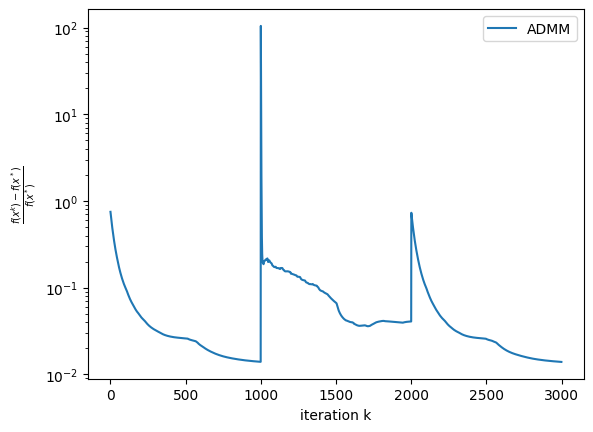

In [135]:
plt.plot(np.abs((obj_val_pd_rest-problem.value)/problem.value), label="ADMM")
plt.xlabel("iteration k")
plt.ylabel(r"$\frac{f(x^k) - f(x^*)}{f(x^*)}$")
plt.yscale('log')
plt.legend()
print("y-axis vals:\n",np.abs((obj_val_pd_rest-problem.value)/problem.value))